# CSI 4142 Data Science 
## Assignment 2 - Data Cleaning

### Identification

Name: Eli Wynn<br/>
Student Number: 300248135

Name: Jack Snelgrove<br/>
Student Number: 300247435


Our datasets have been uploaded from the public repository:

- [github.com/eli-wynn/Datasets](https://github.com/eli-wynn/Datasets)

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

### Importing Datasets

In [2]:
netflix  = "https://raw.githubusercontent.com/eli-wynn/Datasets/refs/heads/main/netflix_titles.csv"
netflixData = pd.read_csv(netflix)
startup = "https://raw.githubusercontent.com/eli-wynn/Datasets/refs/heads/main/startup.csv"
startupData = pd.read_csv(startup)

### Netflix Shows Dataset

#### Dataset Overview
The **Netflix Shows Dataset** was created by **Shivam Bansal**. It contains a comprehensive list of TV shows and movies available on Netflix, including various metadata attributes such as title, type, director, cast, release year, and more. This dataset is useful for data analysis, visualization, and machine learning applications related to content recommendations.

#### Dataset Shape
- **Rows:** 8,801
- **Columns:** 12

#### Features and Descriptions
Below is a list of features included in the dataset along with their descriptions:

##### 1. `show_id` (Categorical)
   - Unique identifier for each show or movie.

##### 2. `type` (Categorical)
   - Specifies whether the content is a **Movie** or a **TV Show**.

##### 3. `title` (Categorical)
   - Title of the movie or TV show.

##### 4. `director` (Categorical, Can be NaN)
   - Name(s) of the director(s) of the content.

##### 5. `cast` (Categorical, Can be NaN)
   - List of main cast members.

##### 6. `country` (Categorical, Can be NaN)
   - Country where the movie or show was produced.

##### 7. `date_added` (Categorical, Can be NaN)
   - Date when the content was added to Netflix.

##### 8. `release_year` (Numerical)
   - Year when the movie or TV show was released.

##### 9. `rating` (Categorical)
   - Content rating (e.g., PG-13, TV-MA, R, G).

##### 10. `duration` (Categorical)
   - Duration of the movie (in minutes) or number of seasons (for TV shows).

##### 11. `listed_in` (Categorical)
   - Categories or genres the content falls under.

##### 12. `description` (Categorical)
   - Brief summary or description of the movie or TV show.

This dataset provides valuable insights into the type of content available on Netflix and allows for various analytical explorations such as trends in movie releases, genre distributions, and rating patterns.


### Clean Data Checker

#### Data Type Error

A data type error occurs when the the data entered into a column doesnt match the data type assigned to that column. There are zero datatype errors in the Netflix dataset


#### Parameters

In [3]:
intCol = ['release_year']
stringCols = ['show_id', 'type', 'title', 'director', 'cast', 'country', 'rating', 'duration', 'listed_in', 'description']

#### Checker Code

In [4]:
for col in intCol:
    netflixData[col] = pd.to_numeric(netflixData[col], errors='coerce')

for col in stringCols:
    invalid_strings = netflixData[~netflixData[col].astype(str).apply(lambda x: isinstance(x, str))]
    if not invalid_strings.empty:
        print(f"\nPossible non-string values in '{col}':\n", invalid_strings.head(5))

#### Findings

In [5]:
# Find rows where conversion resulted in NaN (potential type errors)
type_errors = netflixData[netflixData[intCol].isna().any(axis=1)]
print("Possible data type errors:\n", type_errors)

Possible data type errors:
 Empty DataFrame
Columns: [show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description]
Index: []


#### Range Errors

Searches for errors where the data is outside acceptable range (e.g. season -1 or release date prior to 1930)

#### Parameters

In [6]:
releaseParam = [1925, 2025]
durationParams = [0, 300] #split on space and make sure first item in array is >0 <300
dateAdded = [2007, 2025] #just look at year 

#### Checker Code

In [7]:
releaseErrors = netflixData[(netflixData['release_year'] < releaseParam[0]) | (netflixData['release_year'] > releaseParam[1])]

netflixData['duration_split'] = netflixData['duration'].str.split(" ").str[0]  # Extract number part
netflixData['duration_split'] = pd.to_numeric(netflixData['duration_split'], errors='coerce')  # Convert to int
# Identify invalid durations
durationErrors = netflixData[(netflixData['duration_split'] <= durationParams[0]) | (netflixData['duration_split'] >= durationParams[1])]

netflixData['date_added'] = pd.to_datetime(netflixData['date_added'], errors='coerce')
netflixData['year_added'] = netflixData['date_added'].dt.year #take just year value, other date errors will be caught in format error below
# Identify invalid date_added values
dateAddedErrors = netflixData[(netflixData['year_added'] < dateAdded[0]) | (netflixData['year_added'] > dateAdded[1])]

#### Findings

Only one duration error, a black mirror episode longer than 300 minutes, don't know whether it is just an abnormally long episode outside my set parameters or needs to be cleaned up

In [8]:
print("\nRelease Year Errors:\n", releaseErrors[['title', 'release_year']].head(5))
print("\nDuration Errors:\n", durationErrors[['show_id', 'title', 'duration', 'duration_split']].head(5))
print("\nDate Added Errors:\n", dateAddedErrors[['title', 'date_added', 'year_added']].head(5))


Release Year Errors:
 Empty DataFrame
Columns: [title, release_year]
Index: []

Duration Errors:
      show_id                       title duration  duration_split
4253   s4254  Black Mirror: Bandersnatch  312 min           312.0

Date Added Errors:
 Empty DataFrame
Columns: [title, date_added, year_added]
Index: []


#### Format Errors

Checks for errors with the formatting of the data, e.g. date being DD-MM-YYYY instead of YYYY first

#### Parameters

In [9]:
dateCol = ['date_added'] #make sure date is correct format
showCol = ['show_id'] #make sure it is s### format
durationCol = ['duration'] #make sure duration is number followed by either "min" or "Season" or "Seasons"

#### Checker Code

In [10]:
for col in dateCol:
    netflixData[col] = pd.to_datetime(netflixData[col], errors='coerce')
invalid_dates = netflixData[netflixData[dateCol].isna().any(axis=1)]

brokenID = netflixData[~netflixData['show_id'].astype(str).str.match(r"^s\d{1,4}$", na=False)] #finds all ids that don't match format of s followed by 1-4 #'s
brokenDuration = netflixData[~netflixData['duration'].astype(str).str.match(r"^\d+\s(min|Season|Seasons)$", na=False)] #finds all id's that don't match digits then space then seasons, season or min

#### Findings

Louis C.K. titles have the durations in the ratings column for some reason - formatting is technically correct though
<br> No show ID errors
<br> There are a few date formatting errors

In [11]:
print("\nPossible date format errors:\n", invalid_dates[['title', 'date_added']].head(5))
print("\nShow ID Format Errors:\n", brokenID[['show_id', 'title']].head(5))
print("\nDuration Format Errors:\n", brokenDuration[['duration', 'title']].head(5)) #Louis C.k. durations are in rating column for some reason


Possible date format errors:
                                             title date_added
6066  A Young Doctor's Notebook and Other Stories        NaT
6079                              Abnormal Summit        NaT
6174              Anthony Bourdain: Parts Unknown        NaT
6177                                     忍者ハットリくん        NaT
6213                                Bad Education        NaT

Show ID Format Errors:
 Empty DataFrame
Columns: [show_id, title]
Index: []

Duration Format Errors:
      duration                                 title
5541      NaN                       Louis C.K. 2017
5794      NaN                 Louis C.K.: Hilarious
5813      NaN  Louis C.K.: Live at the Comedy Store


#### Consistency Errors

a type of logical check that ensures data is entered in a
logically consistent manner. In this data a consistensy error could be checking that movies all have their duration in minutes and shows in seasons

#### Parameters

In [12]:
#parameters changed below by updating movie or tv show

#### Checker Code

In [13]:
movieErr = netflixData[(netflixData['type'] == 'Movie')&~netflixData['duration'].astype(str).str.match(r"^\d+\smin$", na=False)]
tvErr = netflixData[(netflixData['type'] == 'TV Show')&~netflixData['duration'].astype(str).str.match(r"^\d+\s(Season|Seasons)$", na=False)] #match all tv show types and regex to ensure consistent season/seasons format

#### Findings

No errors in the consistency just the same duration absences discovered above in the louis C.K. stuff

In [14]:
print("\nIncosistent Movie Durations: \n", movieErr[['title', 'type', 'duration']].head(5))
print("\nIncosistent Show Durations: \n", tvErr[['title', 'type', 'duration']].head(5))



Incosistent Movie Durations: 
                                      title   type duration
5541                       Louis C.K. 2017  Movie      NaN
5794                 Louis C.K.: Hilarious  Movie      NaN
5813  Louis C.K.: Live at the Comedy Store  Movie      NaN

Incosistent Show Durations: 
 Empty DataFrame
Columns: [title, type, duration]
Index: []


#### Uniqueness Errors

Ensure that there are no duplicate values, The title column is the only applicable

#### Parameters

In [15]:
uniquenessParams = ['show_id', 'title', 'release_year']

#### Checker Code

In [16]:
dupeShowID = netflixData[netflixData.duplicated(subset=[uniquenessParams[0]], keep=False)] #showID duplicate

#Checking for duplicate titles isn't valid because two movies can have the same names so need to compare with release year as well
dupeTitle = netflixData[netflixData.duplicated(subset=[uniquenessParams[1], uniquenessParams[2]], keep=False)]

#### Findings

In [19]:
print("\nDuplicate Show IDs: \n", dupeShowID[[uniquenessParams[0]]].head(5))
print("\nDuplicate titles: \n", dupeTitle[[uniquenessParams[1], uniquenessParams[2]]].head(5))


Duplicate Show IDs: 
 Empty DataFrame
Columns: [show_id]
Index: []

Duplicate titles: 
 Empty DataFrame
Columns: [title, release_year]
Index: []


#### Presence Errors

A presence error is when a mandatory value is left blank, in this case you could argue that every column is necessary but title, id and type are the most important

#### Parameters

In [20]:
mandatoryVals = ['show_id', 'title', 'release_year', 'type', 'duration']

#### Checker Code

In [21]:
missingValues = netflixData[netflixData[[mandatoryVals[0], mandatoryVals[1], mandatoryVals[2], mandatoryVals[3], mandatoryVals[4]]].isnull().any(axis=1)]


#### Findings

In [22]:
print("\nMissing mandatory values: \n", missingValues[['show_id', 'title', 
                                                'release_year', 'type', 'duration']].head(5))


Missing mandatory values: 
      show_id                                 title  release_year   type  \
5541   s5542                       Louis C.K. 2017          2017  Movie   
5794   s5795                 Louis C.K.: Hilarious          2010  Movie   
5813   s5814  Louis C.K.: Live at the Comedy Store          2015  Movie   

     duration  
5541      NaN  
5794      NaN  
5813      NaN  


#### Length Errors

Errors in which the length of a parameter is different then the norm. e.g. A title that is 2000 characters long is very likely a length error and an incorrectly input piece of data because 2000 characters is unreasonable to say

#### Parameters

In [23]:
titleSizeParam = [1,200]
relYearParam = [4]

#### Checker Code

In [25]:
titleLen = netflixData[(netflixData['title'].str.len() < titleSizeParam[0]) | (netflixData['title'].str.len() > titleSizeParam[1])]
relYearLen = netflixData[netflixData['release_year'].astype(str).str.len() == releaseParam[0]]

#### Findings

Zero length errors are present given the above criteria

In [27]:
print("\nTitle length errors:")
print(titleLen[['title', 'show_id']].head())
print("\nRelease year length errors found:")
print(relYearLen[['title', 'show_id', 'release_year']].head())


Title length errors:
Empty DataFrame
Columns: [title, show_id]
Index: []

Release year length errors found:
Empty DataFrame
Columns: [title, show_id, release_year]
Index: []


#### Lookup Errors

Errors which are caused by a value being outside the correct set of values. For example, having a made up month in a month of release. In this dataset lookup errors can be present in the country value, rating or type columns

#### Parameters

In [28]:
#Country dictionary sourced from: https://stackoverflow.com/questions/41245330/check-if-a-country-entered-is-one-of-the-countries-of-the-world
Country = [
    ('US', 'United States'),
    ('AF', 'Afghanistan'),
    ('AL', 'Albania'),
    ('DZ', 'Algeria'),
    ('AS', 'American Samoa'),
    ('AD', 'Andorra'),
    ('AO', 'Angola'),
    ('AI', 'Anguilla'),
    ('AQ', 'Antarctica'),
    ('AG', 'Antigua And Barbuda'),
    ('AR', 'Argentina'),
    ('AM', 'Armenia'),
    ('AW', 'Aruba'),
    ('AU', 'Australia'),
    ('AT', 'Austria'),
    ('AZ', 'Azerbaijan'),
    ('BS', 'Bahamas'),
    ('BH', 'Bahrain'),
    ('BD', 'Bangladesh'),
    ('BB', 'Barbados'),
    ('BY', 'Belarus'),
    ('BE', 'Belgium'),
    ('BZ', 'Belize'),
    ('BJ', 'Benin'),
    ('BM', 'Bermuda'),
    ('BT', 'Bhutan'),
    ('BO', 'Bolivia'),
    ('BA', 'Bosnia And Herzegowina'),
    ('BW', 'Botswana'),
    ('BV', 'Bouvet Island'),
    ('BR', 'Brazil'),
    ('BN', 'Brunei Darussalam'),
    ('BG', 'Bulgaria'),
    ('BF', 'Burkina Faso'),
    ('BI', 'Burundi'),
    ('KH', 'Cambodia'),
    ('CM', 'Cameroon'),
    ('CA', 'Canada'),
    ('CV', 'Cape Verde'),
    ('KY', 'Cayman Islands'),
    ('CF', 'Central African Rep'),
    ('TD', 'Chad'),
    ('CL', 'Chile'),
    ('CN', 'China'),
    ('CX', 'Christmas Island'),
    ('CC', 'Cocos Islands'),
    ('CO', 'Colombia'),
    ('KM', 'Comoros'),
    ('CG', 'Congo'),
    ('CK', 'Cook Islands'),
    ('CR', 'Costa Rica'),
    ('CI', 'Cote D`ivoire'),
    ('HR', 'Croatia'),
    ('CU', 'Cuba'),
    ('CY', 'Cyprus'),
    ('CZ', 'Czech Republic'),
    ('DK', 'Denmark'),
    ('DJ', 'Djibouti'),
    ('DM', 'Dominica'),
    ('DO', 'Dominican Republic'),
    ('TP', 'East Timor'),
    ('EC', 'Ecuador'),
    ('EG', 'Egypt'),
    ('SV', 'El Salvador'),
    ('GQ', 'Equatorial Guinea'),
    ('ER', 'Eritrea'),
    ('EE', 'Estonia'),
    ('ET', 'Ethiopia'),
    ('FK', 'Falkland Islands (Malvinas)'),
    ('FO', 'Faroe Islands'),
    ('FJ', 'Fiji'),
    ('FI', 'Finland'),
    ('FR', 'France'),
    ('GF', 'French Guiana'),
    ('PF', 'French Polynesia'),
    ('TF', 'French S. Territories'),
    ('GA', 'Gabon'),
    ('GM', 'Gambia'),
    ('GE', 'Georgia'),
    ('DE', 'Germany'),
    ('GH', 'Ghana'),
    ('GI', 'Gibraltar'),
    ('GR', 'Greece'),
    ('GL', 'Greenland'),
    ('GD', 'Grenada'),
    ('GP', 'Guadeloupe'),
    ('GU', 'Guam'),
    ('GT', 'Guatemala'),
    ('GN', 'Guinea'),
    ('GW', 'Guinea-bissau'),
    ('GY', 'Guyana'),
    ('HT', 'Haiti'),
    ('HN', 'Honduras'),
    ('HK', 'Hong Kong'),
    ('HU', 'Hungary'),
    ('IS', 'Iceland'),
    ('IN', 'India'),
    ('ID', 'Indonesia'),
    ('IR', 'Iran'),
    ('IQ', 'Iraq'),
    ('IE', 'Ireland'),
    ('IL', 'Israel'),
    ('IT', 'Italy'),
    ('JM', 'Jamaica'),
    ('JP', 'Japan'),
    ('JO', 'Jordan'),
    ('KZ', 'Kazakhstan'),
    ('KE', 'Kenya'),
    ('KI', 'Kiribati'),
    ('KP', 'Korea (North)'),
    ('KR', 'Korea (South)'),
    ('KW', 'Kuwait'),
    ('KG', 'Kyrgyzstan'),
    ('LA', 'Laos'),
    ('LV', 'Latvia'),
    ('LB', 'Lebanon'),
    ('LS', 'Lesotho'),
    ('LR', 'Liberia'),
    ('LY', 'Libya'),
    ('LI', 'Liechtenstein'),
    ('LT', 'Lithuania'),
    ('LU', 'Luxembourg'),
    ('MO', 'Macau'),
    ('MK', 'Macedonia'),
    ('MG', 'Madagascar'),
    ('MW', 'Malawi'),
    ('MY', 'Malaysia'),
    ('MV', 'Maldives'),
    ('ML', 'Mali'),
    ('MT', 'Malta'),
    ('MH', 'Marshall Islands'),
    ('MQ', 'Martinique'),
    ('MR', 'Mauritania'),
    ('MU', 'Mauritius'),
    ('YT', 'Mayotte'),
    ('MX', 'Mexico'),
    ('FM', 'Micronesia'),
    ('MD', 'Moldova'),
    ('MC', 'Monaco'),
    ('MN', 'Mongolia'),
    ('MS', 'Montserrat'),
    ('MA', 'Morocco'),
    ('MZ', 'Mozambique'),
    ('MM', 'Myanmar'),
    ('NA', 'Namibia'),
    ('NR', 'Nauru'),
    ('NP', 'Nepal'),
    ('NL', 'Netherlands'),
    ('AN', 'Netherlands Antilles'),
    ('NC', 'New Caledonia'),
    ('NZ', 'New Zealand'),
    ('NI', 'Nicaragua'),
    ('NE', 'Niger'),
    ('NG', 'Nigeria'),
    ('NU', 'Niue'),
    ('NF', 'Norfolk Island'),
    ('MP', 'Northern Mariana Islands'),
    ('NO', 'Norway'),
    ('OM', 'Oman'),
    ('PK', 'Pakistan'),
    ('PW', 'Palau'),
    ('PA', 'Panama'),
    ('PG', 'Papua New Guinea'),
    ('PY', 'Paraguay'),
    ('PE', 'Peru'),
    ('PH', 'Philippines'),
    ('PN', 'Pitcairn'),
    ('PL', 'Poland'),
    ('PT', 'Portugal'),
    ('PR', 'Puerto Rico'),
    ('QA', 'Qatar'),
    ('RE', 'Reunion'),
    ('RO', 'Romania'),
    ('RU', 'Russian Federation'),
    ('RW', 'Rwanda'),
    ('KN', 'Saint Kitts And Nevis'),
    ('LC', 'Saint Lucia'),
    ('VC', 'St Vincent/Grenadines'),
    ('WS', 'Samoa'),
    ('SM', 'San Marino'),
    ('ST', 'Sao Tome'),
    ('SA', 'Saudi Arabia'),
    ('SN', 'Senegal'),
    ('SC', 'Seychelles'),
    ('SL', 'Sierra Leone'),
    ('SG', 'Singapore'),
    ('SK', 'Slovakia'),
    ('SI', 'Slovenia'),
    ('SB', 'Solomon Islands'),
    ('SO', 'Somalia'),
    ('ZA', 'South Africa'),
    ('ES', 'Spain'),
    ('LK', 'Sri Lanka'),
    ('SH', 'St. Helena'),
    ('PM', 'St.Pierre'),
    ('SD', 'Sudan'),
    ('SR', 'Suriname'),
    ('SZ', 'Swaziland'),
    ('SE', 'Sweden'),
    ('CH', 'Switzerland'),
    ('SY', 'Syrian Arab Republic'),
    ('TW', 'Taiwan'),
    ('TJ', 'Tajikistan'),
    ('TZ', 'Tanzania'),
    ('TH', 'Thailand'),
    ('TG', 'Togo'),
    ('TK', 'Tokelau'),
    ('TO', 'Tonga'),
    ('TT', 'Trinidad And Tobago'),
    ('TN', 'Tunisia'),
    ('TR', 'Turkey'),
    ('TM', 'Turkmenistan'),
    ('TV', 'Tuvalu'),
    ('UG', 'Uganda'),
    ('UA', 'Ukraine'),
    ('AE', 'United Arab Emirates'),
    ('UK', 'United Kingdom'),
    ('UY', 'Uruguay'),
    ('UZ', 'Uzbekistan'),
    ('VU', 'Vanuatu'),
    ('VA', 'Vatican City State'),
    ('VE', 'Venezuela'),
    ('VN', 'Viet Nam'),
    ('VG', 'Virgin Islands (British)'),
    ('VI', 'Virgin Islands (U.S.)'),
    ('EH', 'Western Sahara'),
    ('YE', 'Yemen'),
    ('YU', 'Yugoslavia'),
    ('ZR', 'Zaire'),
    ('ZM', 'Zambia'),
    ('ZW', 'Zimbabwe')
]

validCountries = {name for code, name in Country}
validRatings = {"G", "PG", "PG-13", "R", "NC-17", "TV-Y", "TV-Y7", "TV-G", "TV-PG", "TV-14", "TV-MA"}

#### Checker Code

In [29]:
countryError = netflixData[netflixData['country'].notna() & ~netflixData['country'].isin(validCountries)]
ratingError = netflixData[netflixData['rating'].notna() & ~netflixData['rating'].isin(validRatings)]


#### Findings

There are many country lookup errors in the data because my check doesn't account for multiple values inside the country column. There are still errors with the wrong stuff being present in the wrong columns in the louis CK ones as well

In [30]:
print("\nCountry error: \n", countryError[['title', 'show_id', 'country']].head(5))
print("\nRating error: \n", ratingError[['title', 'show_id', 'rating']].head(5))


Country error: 
                   title show_id  \
7               Sankofa      s8   
12         Je Suis Karl     s13   
29             Paranoia     s30   
38  Birth of the Dragon     s39   
46           Safe House     s47   

                                              country  
7   United States, Ghana, Burkina Faso, United Kin...  
12                            Germany, Czech Republic  
29                       United States, India, France  
38                       China, Canada, United States  
46                 South Africa, United States, Japan  

Rating error: 
                                      title show_id  rating
5541                       Louis C.K. 2017   s5542  74 min
5794                 Louis C.K.: Hilarious   s5795  84 min
5813  Louis C.K.: Live at the Comedy Store   s5814  66 min
5971                              (T)ERROR   s5972      NR
5987                            13 Cameras   s5988      NR


#### Exact Duplicate Errors
Exact duplicates occur when multiple rows in the dataset contain the exact same values 
for all attributes


#### Parameters

In [ ]:
duplicate_subset = ['title', 'show_id', 'country']  # Columns to check for exact duplicates


#### Checker Code

In [ ]:
exactDuplicates = netflixData[netflixData.duplicated(subset=duplicate_subset)]

#### Findings

There are no exact duplicates in the dataset

In [ ]:
print("\nExact Duplicate Errors: \n", exactDuplicates[duplicate_subset].head(5))

#### Near Duplicate Errors

Near duplicates are rows that are very similar but have slight differences. This may 
occur due to typos, inconsistent data formatting, or variations in missing values. 

#### Parameters

In [ ]:
#I decided to assume that the titles were correct and am using it as a key to look for near duplicates in comparison
#i.e. duplicates where title matches but other columns differ
titleCol = 'title'
comparisonCols = ['show_id', 'country', 'rating', 'director', 'cast', 'release_year']


#### Checker Code

In [ ]:
nearDuplicates = netflixData[netflixData.duplicated(subset=[titleCol], keep=False)]  # Find rows with duplicate titles

nearDuplicateErrors = nearDuplicates[nearDuplicates.apply(
    lambda row: any(row[comparisonCols] != nearDuplicates[comparisonCols].iloc[0]), #look for differences in comparison columns
    axis=1)]


#### Findings

There are no near duplicates with the same title but different values in the other columns

In [ ]:
print("\nNear Duplicate Errors: \n", nearDuplicateErrors[comparisonCols + [titleCol]].head(5))

### Imputations

#### Test #1

a) Column: Funding Rounds - Numerical<br>


b) Remove 10% of cells in column 'Funding Rounds' - MCAR

We define y_true, which saves the values we remove so that we can evaluate the imputation method in part d

In [ ]:
startupDataMissingValues = startupData.copy()

num_rows = startupDataMissingValues.shape[0]
num_missing = int(num_rows * 0.1)  

missing_indices = np.random.choice(startupDataMissingValues.index, size=num_missing, replace=False)

y_true = startupDataMissingValues.loc[missing_indices, 'Funding Rounds']

startupDataMissingValues.loc[missing_indices, 'Funding Rounds'] = np.nan


c) Method 3: Random Sample Imputation -Univariate

In [ ]:
observed_values = startupDataMissingValues['Funding Rounds'].dropna()

def randomSampleImputation(x):
    if pd.isnull(x):
        return np.random.choice(observed_values)
    else:
        return x

startupDataMissingValues['Funding Rounds'] = startupDataMissingValues['Funding Rounds'].apply(randomSampleImputation)

d) Evaluate approach using Mean Squared Error and Root Mean Squared Error

In [ ]:
y_pred = startupDataMissingValues.loc[missing_indices, 'Funding Rounds']
mse = np.mean((y_true - y_pred)**2)
print('Column Minimum:', startupData['Funding Rounds'].min())
print('Column Maximum:', startupData['Funding Rounds'].max())
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Column Minimum: 1
Column Maximum: 10
MSE: 15.546
RMSE: 3.9428416148762557


After applying random sample imputation to the 'Funding Rounds' column, we evaluated the method using the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). The MSE was calculated to be ~ 15-18, which corresponds to an RMSE of approximately 4 rounds. Considering that the 'Funding Rounds' values range from 1 to 10, this indicates that, on average, our imputed values deviate from the true values by about 4 rounds—nearly 40% of the total range. This substantial error suggests that while random sample imputation may preserve the overall distribution of the observed data, it introduces a significant level of discrepancy, warranting further investigation into alternative imputation strategies.

#### Test #2 

a) Column: Investment Amount

b) If a row has a 'Funding Round' value of 1, it has a 75% chance of having an empty 'Ivestment Amount (USD)' cell, if 'Funding Round' = 2, it has a 30% chance of leaving 'Investment Amount (USD)' blank, and if 'Funding Round = 3, it has a 5% chance of leaving 'Investment Amount (USD) blank. - MAR

Assumption: Startups in early funding rounds might not want to disclode their investment amount yet.

We define y_true, which saves the values we remove so that we can evaluate the imputation method in part d

In [ ]:
startupDataMissingValues2 = startupData.copy()

#assigns a random number to each row between 0-1
random_numbers = np.random.rand(startupDataMissingValues2.shape[0])

prob_1 = 0.75
prob_2 = 0.30
prob_3 = 0.05

shouldRemove = (
    ((startupDataMissingValues2['Funding Rounds'] == 1) & (random_numbers < prob_1)) |
    ((startupDataMissingValues2['Funding Rounds'] == 2) & (random_numbers < prob_2)) |
    ((startupDataMissingValues2['Funding Rounds'] == 3) & (random_numbers < prob_3))
)


y_true = startupDataMissingValues2.loc[shouldRemove, 'Investment Amount (USD)']

startupDataMissingValues2.loc[shouldRemove, 'Investment Amount (USD)'] = np.nan



c) Method 7: Regression Imputation / Predictive Imputation (Bivariate)

In [ ]:
from sklearn.linear_model import LinearRegression

startupDataMissingValues2['Log Investment Amount'] = np.log(startupDataMissingValues2['Investment Amount (USD)'])

train_data = startupDataMissingValues2[startupDataMissingValues2['Log Investment Amount'].notnull()]
pred_data = startupDataMissingValues2[startupDataMissingValues2['Log Investment Amount'].isnull()]

X_train = train_data[['Funding Rounds']]
y_train = train_data['Log Investment Amount']

model = LinearRegression()
model.fit(X_train, y_train)

X_pred = pred_data[['Funding Rounds']]

y_pred = model.predict(X_pred)

startupDataMissingValues2.loc[startupDataMissingValues2['Investment Amount (USD)'].isnull(), 'Investment Amount (USD)'] = y_pred

d) Evaluate the regression model using MSE and RMSE

In [ ]:
from sklearn.metrics import mean_absolute_error


y_pred = startupDataMissingValues2.loc[shouldRemove, 'Investment Amount (USD)']

print('Investment Amount Minimum:', startupData['Investment Amount (USD)'].min())
print('Investment Amount Maximum:', startupData['Investment Amount (USD)'].max())

mse = np.mean((y_true - y_pred)**2)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_true, y_pred)
print(mae)

Investment Amount Minimum: 1102610.0
Investment Amount Maximum: 4999543707.18
MSE: 1.561587135752324e+17
RMSE: 395169221.4421973
331859979.16259605


After applying regression/predictive imputation to the 'Investment Amount (USD)' column, we evaluated the method using the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). The MSE was calculated to be ~ 7 Quintilion - 8 Quintilion which corresponds to an RMSE of approximately 2.7 Billion - 2.9 Billion dollars. Considering that the 'Investment Amount (USD)' values range from 1 Million to 5 Billion, this indicates that, on average, our imputed values deviate from the true values by about 2.8 Billion dollars —nearly 60% of the total range. This regression model preformed really poorly in predicting Investment Amount. This could be for numerous reasons but it is probably because investment amount isnt strongly correlated with other columns in the data frame. I would recommend simply removing the row from the set as predicting this value or using other imputation methods are bound to be inacurate due to the nature of the column in this domain. 

#### Test #3

a) Column: Valuation (USD)

b) Remove all Valuations under $1,000,000,000

Assumption: Companies with Valuations under $1,000,000,000 want to keep that information confidential so they do not appear as small

In [ ]:
startupDataMissingValues3= startupData.copy()

shouldRemove= startupDataMissingValues3['Valuation (USD)']<=1000000000


y_true = startupDataMissingValues3.loc[shouldRemove, 'Valuation (USD)']
startupDataMissingValues3.loc[shouldRemove, 'Valuation (USD)'] = np.nan



c) Method 9: Similarity Based Imputation (Multivariate)

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer


startupDataMissingValues3 = pd.get_dummies(startupDataMissingValues3, columns=['Startup Name','Industry', 'Country'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(startupDataMissingValues3)

imputer = KNNImputer(n_neighbors=2)

imputed_array = imputer.fit_transform(startupDataMissingValues3)
startupDataMissingValues3 = pd.DataFrame(imputed_array, columns=startupDataMissingValues3.columns, index=startupDataMissingValues3.index)
startupDataMissingValues3['Valuation (USD)'] = scaler.inverse_transform(startupDataMissingValues3)[..., 1]


y_pred= startupDataMissingValues3.loc[shouldRemove, 'Valuation (USD)'] 


d) Evaluate the KNN (Similarity Based) Imputer with mean absolute error

MAE: 331859979.16259605


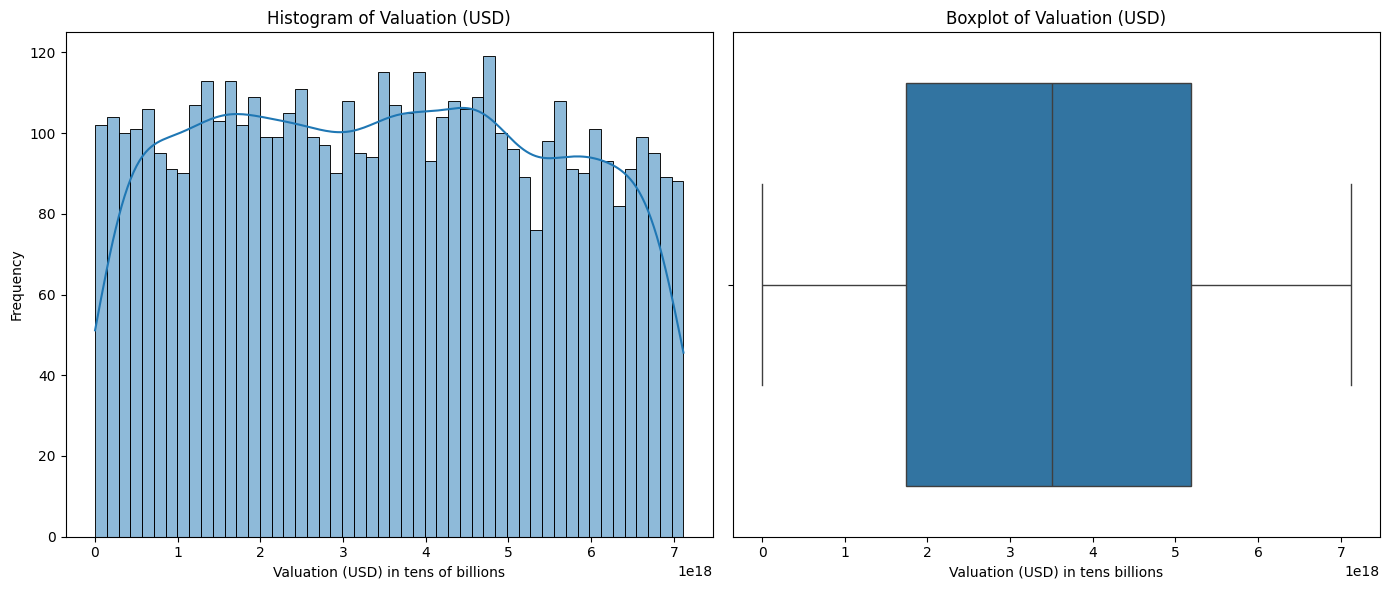

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)

plt.figure(figsize=(14, 6))

# Histogram with KDE to see the distribution and skew
plt.subplot(1, 2, 1)
sns.histplot(startupData['Valuation (USD)'], bins=50, kde=True)
plt.title("Histogram of Valuation (USD)")
plt.xlabel("Valuation (USD) in tens of billions")
plt.ylabel("Frequency")

# Boxplot to visualize the range and detect outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=startupData['Valuation (USD)'])
plt.title("Boxplot of Valuation (USD)")
plt.xlabel("Valuation (USD) in tens billions")

plt.tight_layout()
plt.show()

The MAE of approximately $331.86 million indicates that, on average, the KNN imputation method is off by that amount when predicting "Valuation (USD)".

### Conclusion

Overall the data was very clean already with only a few errors being present with the duration format, stuff not having a date added. There are a lot of issues with the titles with Louis C.K. as the director and items being stored in the wrong columns. There are also a bunch of lookup errors to do with the country of origin, with criteria currently used it just checks whether the string of country is == to the string in the dictionary which fails when there is multiple countries as the string is different even if the country values are the same. 